## Library and data imports##

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# reads in all reviews
df = pd.read_csv('data.csv')
reviews = df['review']
y_pre = df['voted_up']


## Dealing with imbalanced data ##
This would be where we deal with the fact that most of the reviews are positive and will probably do subsampling

In [2]:
from random import sample

# subsamples data so that the ratio of upvotes vs downvotes is 1:1

up = df[df['voted_up'] == True]
down = df[df['voted_up'] == False]
print(len(down)/len(up))

df_sub = down
df_sub = pd.concat([df_sub, (up.sample(n=len(down)))])

print(len(down))
print(len(df_sub))

0.33547876680154604
40708
81416


In [3]:
reviews = np.array(df_sub['review'])
y_pre = np.array(df_sub['voted_up'])

## Tokenization ##
Can cover the following hyperparameters (and their tuning):
- How do we deal with contractions?
- What kind of normalization do we do? (convert accents to ascii? stemming? lemmatization?)
- Do we use stopwords? Which ones?
- Other CountVectorizer hyperparams
- How do we handle punctuation?  
- How much should we subsample? (Need to determine performance metric first)

In [4]:
# preprocessing so the model can understand the reviews
pp_reviews = []
y = []

# filters out reviews with non-ascii characters -- we get an error if we don't include this
for i in range(0, len(reviews)-1):
    if str(reviews[i]).isascii():
        pp_reviews.append(str(reviews[i]))
        y.append(y_pre[i])

In [5]:
from sklearn.svm import LinearSVC

# LinearSVC is the best performing model we tested (results towards the bottom of this notebook)

# Used to optimize preprocessing configuration. Gets testing accuracy with the optimal LinearSVC hyperparameters
def get_training_accuracy(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)

    clf = LinearSVC(random_state=42, dual='auto', max_iter=1000, C=1)
    clf.fit(X_val, y_val)
    y_pred = clf.predict(X_subtrain)
    return accuracy_score(y_subtrain, y_pred)

In [6]:
def do_vectorization_transformation(count_vect, X):
    # tokenizes the reviews
    X_train_counts = count_vect.fit_transform(np.array(X))

    # transforms them so we deal with term frequencies rather than term counts
    tfidf_transformer = TfidfTransformer()
    X = tfidf_transformer.fit_transform(X_train_counts)
    return X

In [60]:
# configuring hyperparameters for the count vectorizer

# baseline accuracy -- no preprocessing tuning
count_vect = CountVectorizer()
X = do_vectorization_transformation(count_vect, pp_reviews)
print("baseline: " + str(get_training_accuracy(X, y)))

baseline: 0.8266760579043947


In [61]:
# configuring max_df/min_df (min/max frequencies for adding new stopwords based on this specific dataset)
x_graph = []
y_graph = []
z_graph = []
for min_df in np.arange(0, 1.1, 0.1):
    for max_df in np.arange(min_df, 1.1, 0.1):
        try:
            count_vect = CountVectorizer(min_df=min_df, max_df=max_df)
            X = do_vectorization_transformation(count_vect, pp_reviews)
            acc = get_training_accuracy(X, y)
            print("min_df: " + str(round(min_df,2)) + ", max_df: " + str(round(max_df,2)) + ": " + str(acc))
            x_graph.append(min_df)
            y_graph.append(max_df)
            z_graph.append(acc)
        except:
            pass

min_df: 0.0, max_df: 0.1: 0.8032288558136087
min_df: 0.0, max_df: 0.2: 0.8177049544957461
min_df: 0.0, max_df: 0.3: 0.8181498025986543
min_df: 0.0, max_df: 0.4: 0.8263794925024559
min_df: 0.0, max_df: 0.5: 0.8261199977757595
min_df: 0.0, max_df: 0.6: 0.8262312098014866
min_df: 0.0, max_df: 0.7: 0.8266760579043947
min_df: 0.0, max_df: 0.8: 0.8266760579043947
min_df: 0.0, max_df: 0.9: 0.8266760579043947
min_df: 0.0, max_df: 1.0: 0.8266760579043947
min_df: 0.1, max_df: 0.2: 0.6622305425293322
min_df: 0.1, max_df: 0.3: 0.6749643194750793
min_df: 0.1, max_df: 0.4: 0.6936108691219811
min_df: 0.1, max_df: 0.5: 0.6937220811477081
min_df: 0.1, max_df: 0.6: 0.6946303126911457
min_df: 0.1, max_df: 0.7: 0.6947229893792516
min_df: 0.1, max_df: 0.8: 0.6947229893792516
min_df: 0.1, max_df: 0.9: 0.6947229893792516
min_df: 0.1, max_df: 1.0: 0.6947229893792516
min_df: 0.2, max_df: 0.3: 0.5979685269967192
min_df: 0.2, max_df: 0.4: 0.6290522881874293
min_df: 0.2, max_df: 0.5: 0.6299790550684881
min_df: 0.

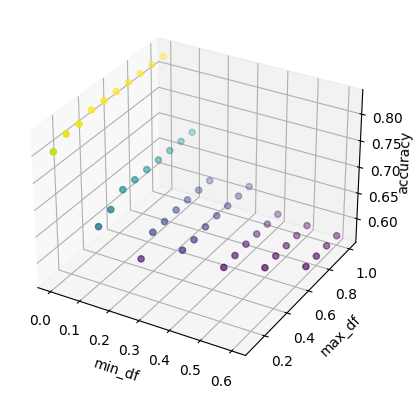

In [64]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_graph, y_graph, z_graph, c=z_graph);
ax.set_xlabel('min_df')
ax.set_ylabel('max_df')
ax.set_zlabel('accuracy', rotation=90)
ax.zaxis.labelpad=-1
plt.show()

With all other factors equal, the best min_df/max_df combination was 0.0, 0.5 with testing accuracy of 0.8267 when using an SVC

In [7]:
# with/without stopwords
# taken from NLTK stopword set, stripped of punctuation
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'dont', 'should', 'shouldve', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'arent', 'couldn', 'couldnt', 'didn', 'didnt', 'doesn', 'doesnt', 'hadn', 'hadnt', 'hasn', 'hasnt', 'haven', 'havent', 'isn', 'isnt', 'ma', 'mightn', 'mightnt', 'mustn', 'mustnt', 'needn', 'neednt', 'shan', 'shant', 'shouldn', 'shouldnt', 'wasn', 'wasnt', 'weren', 'werent', 'won', 'wont', 'wouldn', 'wouldnt']
count_vect = CountVectorizer(stop_words=stopwords)
X = do_vectorization_transformation(count_vect, pp_reviews)
print("with stopwords: " + str(get_training_accuracy(X, y)))

with stopwords: 0.8061116770071303


The testing performance with stopwords was slightly actually worse than without, with an decrease in performance of of 0.021

In [8]:
# min/max n-gram values (min and max length of phrases to use as features)
# Ex. "game not good" with min_n=1, max_n=3 would tokenize into ["game", "not", "good", "game not", "not good", "game not good"]

x_graph_n = []
y_graph_n = []
z_graph_n = []
for min_n in np.arange(2, 10):
    for max_n in np.arange(min_n, 10):
        try:
            count_vect = CountVectorizer(ngram_range=(min_n, max_n))
            X = do_vectorization_transformation(count_vect, pp_reviews)
            acc = get_training_accuracy(X, y)
            print("min_n: " + str(min_n) + ", max_n: " + str(max_n) + ": " + str(acc))
            x_graph_n.append(min_n)
            y_graph_n.append(max_n)
            z_graph_n.append(acc)
        except:
            pass
# this was prone to crashing from using too much memory, so accumulated results have been displayed below in markdown

min_n: 2, max_n: 2: 0.7974627280303732
min_n: 2, max_n: 3: 0.7831836281137142
min_n: 2, max_n: 4: 0.7695156958977684
min_n: 2, max_n: 5: 0.7596073710528752
min_n: 2, max_n: 6: 0.7529215668117418
min_n: 2, max_n: 7: 0.7474766182053894
min_n: 2, max_n: 8: 0.74418001666821
min_n: 2, max_n: 9: 0.7406426520974164
min_n: 3, max_n: 3: 0.7114918047967405
min_n: 3, max_n: 4: 0.6887674784702287
min_n: 3, max_n: 5: 0.6658949902768775
min_n: 3, max_n: 6: 0.6451893693860543
min_n: 3, max_n: 7: 0.6255394017964626
min_n: 3, max_n: 8: 0.6097786832114085
min_n: 3, max_n: 9: 0.5935179183257709
min_n: 4, max_n: 4: 0.5752940087045096
min_n: 4, max_n: 5: 0.5394017964626354
min_n: 4, max_n: 6: 0.5219186961755719
min_n: 4, max_n: 7: 0.5143254005000463
min_n: 4, max_n: 8: 0.5100472265950551
min_n: 4, max_n: 9: 0.5068617464580054
min_n: 5, max_n: 5: 0.5078247985924622
min_n: 5, max_n: 6: 0.5020650060190759
min_n: 5, max_n: 7: 0.49963885544957864
min_n: 5, max_n: 8: 0.4984165200481526
min_n: 5, max_n: 9: 0.4978

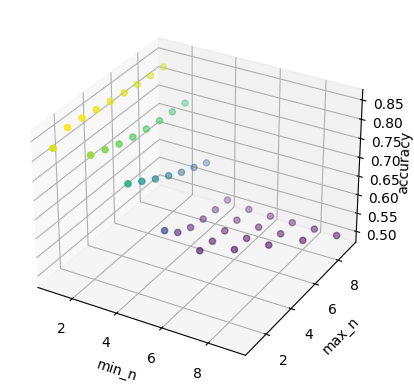

In [16]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# values taken from the above markdown output
x_graph_new = x_graph_n + [1,1,1,1,1,1,1,1,1]
y_graph_new = y_graph_n + [1,2,3,4,5,6,7,8,9]
z_graph_new = z_graph_n + [0.8266760579043947,0.8509944208633761,0.8480473021816093,0.8423198828566663,0.8363144334674056,0.8320513058145355,0.8278067134992864,0.8247483827917925,0.8219866174862375]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_graph_new, y_graph_new, z_graph_new, c=z_graph_new);
ax.set_xlabel('min_n')
ax.set_ylabel('max_n')
ax.set_zlabel('accuracy', rotation=90)
ax.zaxis.labelpad=-1
plt.show()

With all other factors equal, the best n-gram combination was (1, 2) with a testing accuracy of 0.8510 when using an SVM

training accuracy with optimal configuration with each individual preprocessing hyperparameter: 0.9959811372733313


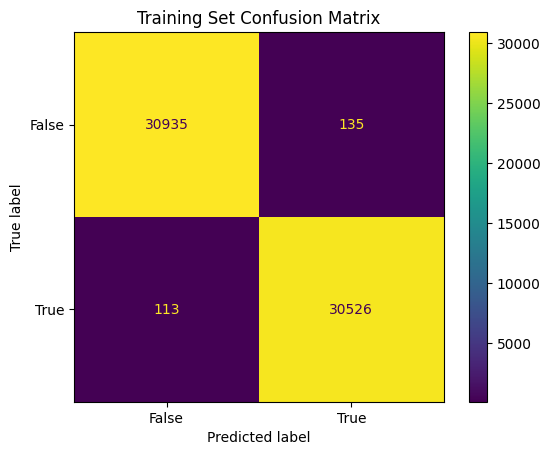

testing accuracy with optimal configuration with each individual preprocessing hyperparameter: 0.884171635986518


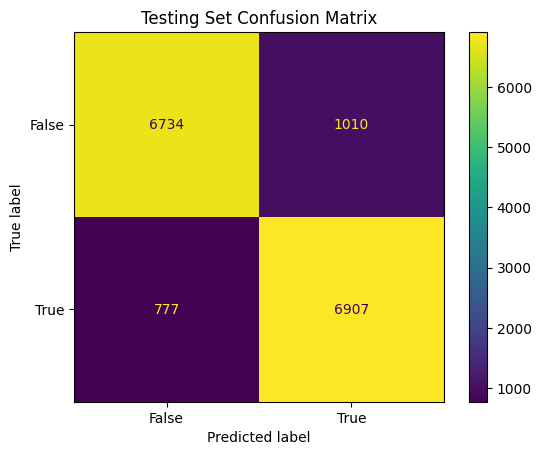

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# using the optimal configuration from all previous hyperparameter testing
count_vect = CountVectorizer(ngram_range=(1, 2), min_df=0.0, max_df=0.5)
X = do_vectorization_transformation(count_vect, pp_reviews)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LinearSVC(random_state=42, dual='auto', max_iter=1000, C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print("training accuracy with optimal configuration with each individual preprocessing hyperparameter: " + str(accuracy_score(y_train, y_pred)))
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_plot.plot()
plt.title("Training Set Confusion Matrix")
plt.show()

clf = LinearSVC(random_state=42, dual='auto', max_iter=1000, C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("testing accuracy with optimal configuration with each individual preprocessing hyperparameter: " + str(accuracy_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_plot.plot()
plt.title("Testing Set Confusion Matrix")
plt.show()

## Model Training ##

In [10]:
from sklearn.metrics import confusion_matrix

count_vect = CountVectorizer(ngram_range=(1, 2))
X = do_vectorization_transformation(count_vect, pp_reviews)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train)
y_pred = sgd_classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(get_training_accuracy(X, y))

[[6606 1161]
 [ 968 6715]]
0.862200647249191


In [48]:
from sklearn.svm import LinearSVC
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)
clf = LinearSVC(random_state=42, dual='auto')
clf.fit(X_subtrain, y_subtrain)
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[3321  505]
 [ 408 3485]]
0.8817204301075269


1000 0.01 0.8449194891726819
1000 0.1 0.9365907828983898
1000 1 0.996446418656302
1000 10 0.9977419951878586
1000 100 0.9977605034240237
1000 1000 0.9977234869516936
10000 0.01 0.8449194891726819
10000 0.1 0.9365907828983898
10000 1 0.996446418656302
10000 10 0.9977419951878586
10000 100 0.9977605034240237
10000 1000 0.9977605034240237
100000 0.01 0.8449194891726819
100000 0.1 0.9365907828983898
100000 1 0.996446418656302
100000 10 0.9977419951878586
100000 100 0.9977605034240237


# Decision Tree

In [11]:
from sklearn import tree

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X_subtrain, y_subtrain)
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[2703 1168]
 [1037 2817]]
0.7145631067961165


# K-Nearest

In [13]:
from sklearn.neighbors import KNeighborsClassifier
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)
clf = KNeighborsClassifier()
clf.fit(X_subtrain, y_subtrain)
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[  92 3779]
 [   8 3846]]
0.5097734627831715


# SGD Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)
clf = SGDClassifier(random_state=42)
clf.fit(X_subtrain, y_subtrain)
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[3250  621]
 [ 454 3400]]
0.86084142394822


# Linear SVC

In [15]:
from sklearn.svm import LinearSVC
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)
clf = LinearSVC(random_state=42, dual='auto')
clf.fit(X_subtrain, y_subtrain)
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[3362  509]
 [ 423 3431]]
0.8793527508090615


# MLP Classifier

In [18]:
from sklearn.neural_network import MLPClassifier
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)
clf = MLPClassifier(activation="tanh", solver="sgd",
                            hidden_layer_sizes=(1, 1000), learning_rate_init=0.1)
clf.fit(X_subtrain, y_subtrain)
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[3487  384]
 [ 675 3179]]
0.8629126213592233


# Hyperperameters

In [20]:
import warnings
warnings.filterwarnings("ignore")

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123)

for max_iter_i in [1000, 10000]:
    for C_i in [0.01, 0.1, 1, 10, 100, 1000]:
        clf = LinearSVC(max_iter=max_iter_i, C=C_i)
        clf.fit(X_subtrain, y_subtrain)
        y_pred = clf.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        print(max_iter_i, C_i, score)

1000 0.01 0.8245954692556634
1000 0.1 0.8709385113268608
1000 1 0.8793527508090615
1000 10 0.8772815533980582
1000 100 0.8717152103559871
1000 1000 0.8714563106796116
10000 0.01 0.8245954692556634
10000 0.1 0.8709385113268608
10000 1 0.8793527508090615
10000 10 0.8772815533980582
10000 100 0.8714563106796116
10000 1000 0.8709385113268608


In [ ]:
for max_iter_i in [100000, 1000000]:
    for C_i in [0.01, 0.1, 1, 10, 100, 1000]:
        clf = LinearSVC(max_iter=max_iter_i, C=C_i)
        clf.fit(X_subtrain, y_subtrain)
        y_pred = clf.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        print(max_iter_i, C_i, score)

100000 0.01 0.8245954692556634
100000 0.1 0.8709385113268608
100000 1 0.8793527508090615
100000 10 0.8772815533980582
100000 100 0.8714563106796116
